# Logistic Regression

*From‑Scratch & scikit‑learn implementation*

## Introduction

## Why Logistic Regression?

Logistic regression is the workhorse of **binary classification**—the task of predicting whether an observation belongs to class 0 or class 1.  
Despite its name, it is **not** a regression algorithm for continuous targets; rather, it models the *probability* of class membership using a logistic (sigmoid) curve.

* **Intuition**  
  - Linear regression lets predicted values wander from $-\infty$ to $+\infty$.  
  - Classification, however, demands outputs bounded in $[0,1]$ so they can be interpreted as probabilities.  
  - Logistic regression achieves this by passing a linear combination of features through the sigmoid function:
    $$
      \hat{p} = \sigma(z) = \frac{1}{1 + e^{-z}},\quad 
      \text{where } z = \beta_0 + \beta_1x_1 + \dots + \beta_kx_k.
    $$

* **Why start here?**  
  - It is **interpretable**: coefficients translate into *odds ratios* that non-technical stakeholders grasp.  
  - It scales gracefully from a single predictor to thousands of sparse features.  
  - Many modern classifiers (neural nets, transformers) still end with a logistic layer for binary outputs.


* **What you’ll learn in this notebook**  
  1. The mathematical foundations: likelihood, log-odds, and cross-entropy loss.  
  2. A from-scratch NumPy implementation using gradient descent.  
  3. A production-ready approach with `scikit-learn`.
  4. Practical tips: handling class imbalance, feature scaling, regularisation, and model interpretation.

By mastering logistic regression, you build a solid springboard to more advanced classification techniques while retaining a firm grasp on the underlying statistics.


## When to Use Linear vs. Logistic Regression

| Scenario | **Linear Regression** | **Logistic Regression** |
|---|---|---|
| **Nature of the target** | Continuous, unbounded numeric outcome (e.g., revenue, temperature) | Categorical – most often binary—outcome (e.g., churn yes/no, disease present/absent) |
| **Goal** | Estimate the conditional mean of *y* given *X* | Estimate $P(y=1 \mid X)$ and/or assign class labels |
| **Core likelihood / assumptions** | Gaussian errors, constant variance, linear mean function | Binomial likelihood; log-odds are a linear function of predictors |
| **Coefficient interpretation** | Slope = expected change in *y* per unit change in *x* | Coefficient = change in log-odds (or multiplicative change in the odds ratio) per unit change in *x* |
| **Typical evaluation metrics** | RMSE, MAE, $R^{2}$ | Accuracy, Precision-Recall, ROC-AUC, Log-loss |
| **Common pitfalls** | Produces impossible values for bounded targets; sensitive to heteroscedasticity | Misleading accuracy on imbalanced classes; assumes a linear decision boundary |
| **Example use cases** | Forecasting sales, predicting house prices | Fraud detection, spam classification, medical diagnosis |

**Rule of thumb**

* Use **linear regression** when the dependent variable is numeric and unbounded and you care about predicting its magnitude.  
* Use **logistic regression** when the dependent variable represents category membership (especially a yes/no outcome) and you need well-calibrated probabilities confined to the $[0,1]$ interval.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Loading and Exploring the Data

### Wisconsin Diagnostic Breast Cancer (WDBC) Dataset — Overview

| Aspect | Details |
|--------|---------|
| **Origin** | Collected at the University of Wisconsin–Madison; archived on the UCI Machine Learning Repository. |
| **Objective** | Distinguish **malignant** from **benign** breast‐tumor samples based on features computed from digitized images of fine-needle aspirate (FNA) biopsies. |
| **Observations** | **569** cases (rows). |
| **Target variable** | `target` – binary label (0 = malignant, 1 = benign). |
| **Class balance** | 212 malignant (≈ 37 %), 357 benign (≈ 63 %). |
| **Predictor variables** | 30 continuous attributes describing cell‐nucleus morphology; for each of 10 raw measurements — `radius`, `texture`, `perimeter`, `area`, `smoothness`, `compactness`, `concavity`, `concave points`, `symmetry`, `fractal_dimension` — three summary statistics are recorded: <br> • **mean** over all nuclei in the image <br> • **standard error (SE)** <br> • **“worst”/max** value |
| **Feature scale & units** | All features are real-valued and on heterogeneous scales (e.g., radius in pixels, area in pixel²). Standardisation is recommended before model fitting. |
| **Missing values** | None; the matrix is complete. |
| **Data format in `sklearn`** | `load_breast_cancer(as_frame=True)` returns: <br> • `.frame` → `pandas.DataFrame` with the 30 features **plus** the `target` column. <br> • `.target_names` → `['malignant', 'benign']` <br> • `.feature_names` → ordered list of the 30 predictor names <br> • `.DESCR` → full text description. |
| **Typical ML usage** | Benchmark for binary classification algorithms, feature‐selection experiments, model interpretability studies, and demonstrations of class-imbalance handling. |

**Key point**: Each feature captures a different aspect of cell morphology; malignant tumours generally exhibit larger, more irregular, and less symmetrical nuclei, which is why models trained on this dataset often achieve high discriminative performance.


In [2]:
# Load dataset
data = load_breast_cancer(as_frame=True)
df = data.frame

X = df.drop(columns=['target'])
y = df['target']

df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


## Initial Checks
I am not focusing on exploratory data analysis (EDA) in this notebook. However, I will perform some basic data checks to identify any potential issues with the dataset.

Specifically, I want to verify:
- that all data types are correct (e.g., no unexpected characters in numeric variables),
- that there are no missing values,
- and that the variables exhibit some variance.

In [3]:
# Missing values
df_missing = pd.DataFrame(df.isna().sum(), columns = ['missing_values'])
df_missing['percent'] = df_missing['missing_values'] / len(df)
df_missing.head(50)

,missing_values,percent
mean radius,0,0.0
mean texture,0,0.0
mean perimeter,0,0.0
mean area,0,0.0
mean smoothness,0,0.0
mean compactness,0,0.0
mean concavity,0,0.0
mean concave points,0,0.0
mean symmetry,0,0.0
mean fractal dimension,0,0.0


In [4]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
# Describe
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


For this notebook, we are not focused on performance — our goal is simply to understand how logistic regression works.

That said, we need to ensure that our dataset contains **exactly two classes** in the target variable, and that there are **sufficient examples of both classes**. \
Otherwise, the model won’t be able to learn meaningful decision boundaries, and the training process might fail or produce misleading results.

In practice, this means:

- Checking that the target variable is binary (e.g., 0 and 1).
- Confirming that both classes are represented with a reasonable number of observations.
- Avoiding highly imbalanced datasets, as they can distort interpretation in educational examples.

Once we’ve verified class balance, we can safely proceed to fitting and interpreting logistic regression models.


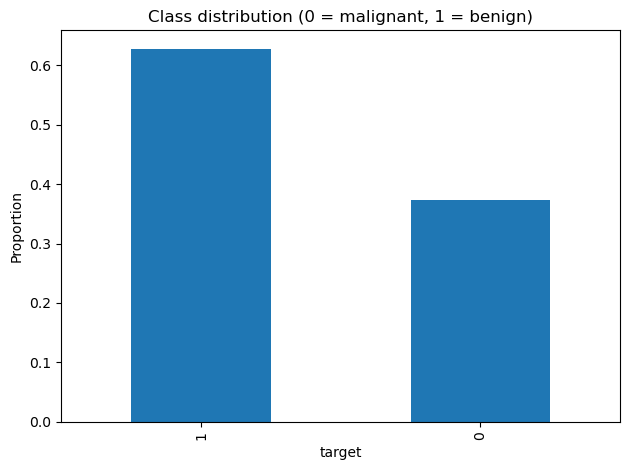

In [6]:
y.value_counts(normalize=True).plot(kind='bar');
plt.title('Class distribution (0 = malignant, 1 = benign)')
plt.ylabel('Proportion')
plt.tight_layout()

### Data Preparation: Train–Test Split & Feature Scaling

Before training the model, we need to:

- **Separate features and target**  (Already done!)
  - Before fitting a model we must **isolate what we are going to predict** and **prepare the data in a way that avoids information leakage**.
  - X contains all explanatory variables.
  - y is the binary label (0 = malignant, 1 = benign in the breast-cancer example).

- **Create a hold-out set**  
  - test_size=0.2 reserves 20 % of the data for final evaluation.
  - stratify=y keeps the original class distribution in both splits—crucial for balanced performance metrics on imbalanced datasets.
  - random_state guarantees reproducible splits.

- **Standardise the features**  
  - Many optimisation algorithms (including gradient descent) converge faster when inputs have zero mean and unit variance.
  - We fit the scaler only on the training data to avoid peeking at the test set, then transform both splits with the same parameters—this prevents data leakage.

- **Verify the result**  
  - Verifying the sample counts ensures the split happened as expected and helps catch accidental filtering or indexing errors early.

With a clean split and properly scaled features, we are ready to fit logistic-regression models and assess their generalisation performance.


## More about Standardise the features

### Why Standardising Aids Coefficient Interpretation and Significance Tests

Logistic-regression coefficients measure the change in log-odds produced by a one-unit increase in a predictor, but a “unit” can mean wildly different things across variables:

| Variable        | Raw unit     | Typical range         |
|----------------|--------------|------------------------|
| age            | 1 year       | 18 – 90                |
| annual_income  | 1 dollar     | 20,000 – 300,000       |
| tumour_radius  | 1 millimetre | 6 – 30                 |

Because the scales differ by orders of magnitude, the raw coefficients are not directly comparable:

- A tiny coefficient on `annual_income` may look unimportant only because dollars are small units.
- A large coefficient on `tumour_radius` may look dominant simply because millimetres are coarse.

---

### How Standardisation Fixes This

Standardising transforms every predictor to have mean 0 and standard deviation 1:

$$
x^* = \frac{x - \bar{x}}{s}
$$

A one-unit change in $ x^* $ now means one standard deviation in the original units.

**Coefficients therefore quantify the change in log-odds per equally sized shift across all variables**, making magnitudes directly comparable.

---

### Interpretation Shortcut

If the standardised coefficient of `tumour_radius` is 0.8 and that of `texture_variance` is 0.2:

- A one-SD increase in radius multiplies the odds roughly $ e^{0.8} \approx 2.2 $ times.
- The same relative increase in texture multiplies the odds by only $ e^{0.2} \approx 1.2 $ times.

---

### Impact on Statistical Significance

*p*-values and *z*-scores depend on the ratio:

$$
\frac{\beta}{SE(\beta)}
$$

Standardisation rescales both the numerator (coefficient) and the denominator (standard error) by the same factor, so **significance tests remain mathematically identical**.

What changes is our ability to compare effect sizes, because coefficients are now expressed in commensurate units.

---

### Practical Example

Suppose we model employee attrition using:

- `salary_usd`
- `years_at_company`
- `engagement_score` (0–1)

Without scaling, the largest coefficient may attach to `engagement_score` purely because its domain is small. After standardising:

- The coefficient for `salary_usd` might grow substantially (one SD ≈ \$15,000) and reveal that salary has a stronger impact on quit-probability than raw numbers suggested.
- `engagement_score`’s coefficient may shrink, clarifying that improving engagement by one SD (≈ 0.12 points) is **less influential** than a comparable relative boost in salary.

---

### **Takeaway**

Standardising features **does not alter statistical significance**, but it **does make coefficient magnitudes, odds ratios, and regularisation penalties directly comparable across predictors** — essential for:

- Ranking variable importance  
- Communicating results to stakeholders


In [7]:
# Train‑test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

In [8]:
# Standardise features    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Training samples:', X_train.shape[0])
print('Test samples:', X_test.shape[0])

Training samples: 455
Test samples: 114


## Logistic Regression From Scratch — Mathematical Walk-through

---

#### 1. Model Specification

For binary outcomes $ y \in \{0,1\} $, we posit:

$$
\Pr(y=1 \mid \mathbf{x}) = \hat{p}(\mathbf{x}; \boldsymbol{\beta}) = \sigma(\mathbf{x}^\top \boldsymbol{\beta}), \quad \text{where} \quad \sigma(z) = \frac{1}{1 + e^{-z}}
$$


- $ \mathbf{x} = (1, x_1, \dots, x_k)^\top $ includes a leading 1 for the intercept  
- $ \boldsymbol{\beta} =$beta_0, \beta_1, \dots, \beta_k)^\top $ are the parameters we must learn 
- $ \sigma(\cdot) $ maps any real number to the interval (0, 1)

Taking logs of the odds yields the familiar linear log-odds relationship:

$$
\log\left[\frac{\hat{p}}{1 - \hat{p}}\right] = \mathbf{x}^\top \boldsymbol{\beta}
$$

---

#### 2. Likelihood and Loss

Given $ m $ independent observations $ \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^{m} $, the Bernoulli likelihood is:

$$
L$boldsymbol{\beta}) = \prod_{i=1}^{m} \hat{p}^{y^{(i)}} (1 - \hat{p})^{1 - y^{(i)}}
$$

Maximising the likelihood is equivalent to minimising the **negative log-likelihood** (also called **cross-entropy loss**):

$$
J$boldsymbol{\beta}) = - \sum_{i=1}^{m} \left[ y^{(i)} \log \hat{p}^{(i)} + (1 - y^{(i)}) \log(1 - \hat{p}^{(i)}) \right]
$$

where $ \hat{p}^{(i)} = \sigma(\mathbf{x}^{(i)\top} \boldsymbol{\beta}) $

---

#### 3. Gradient of the Loss

To minimise $ J $, we need its gradient. Using $ \frac{\partial \sigma}{\partial z} = \sigma(1 - \sigma) $:

$$
\nabla_{\boldsymbol{\beta}} J = \sum_{i=1}^{m} $hat{p}^{(i)} - y^{(i)}) \mathbf{x}^{(i)}
$$

This vector points in the direction of steepest **increase** of the loss; moving opposite to it **reduces** the loss.

---

#### 4. Gradient-Descent Update Rule

With learning rate $ \eta > 0 $:

$$
\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} - \eta \nabla_{\boldsymbol{\beta}} J$boldsymbol{\beta}^{(t)})
$$

Repeat this step until convergence (e.g., loss stabilises or gradient norm is very small).

---

#### 5. Why Not Use a Closed-Form Solution?

- **No analytic normal equations**: Unlike OLS, the logistic loss is **non-quadratic**, and setting $ \nabla_{\boldsymbol{\beta}} J = 0 $ yields **non-linear** equations.
- **Iterative methods are unavoidable**: Practical solvers rely on:
  - First-order: Gradient descent, stochastic gradient descent (SGD)
  - Second-order: Newton’s method, L-BFGS

**Gradient descent scales better**:
- Memory: $ O(k) $
- Per-epoch cost: $ O(mk) $
- Closed-form would require inverting a $ (k+1) \times (k+1) $ matrix (cost: $ O(k^3) $), which is infeasible for high-dimensional problems.

---

#### 6. Summary of the “From-Scratch” Procedure

1. Initialise $ \boldsymbol{\beta} $ (e.g., zeros)
2. Repeat:
   - Compute predictions $ \hat{p}^{(i)} $ via the sigmoid
   - Evaluate the gradient $ \nabla_{\boldsymbol{\beta}} J $
   - Update parameters using learning rate
3. Terminate when convergence criteria are met

This manual gradient-descent routine reproduces the essential mechanics hidden inside high-level libraries, giving you full control over:
- Learning rates  
- Stopping conditions  
- Regularisation  

It also deepens your intuition about how logistic regression learns from data.


### Why Logistic Regression Has No Closed-Form Solution

---

#### 1. What “Linear in the Log-Odds” Really Means

Logistic regression postulates:

$$
\Pr(y = 1 \mid \mathbf{x}) = \sigma(z), \quad z = \mathbf{x}^\top \boldsymbol{\beta}
$$

So:

$$
\log\left[\frac{p}{1 - p}\right] = \mathbf{x}^\top \boldsymbol{\beta}
$$

The right-hand side is **linear in the parameters**, but you never observe $ \log\left[\frac{p}{1 - p}\right] $.  
You only observe $ y \in \{0, 1\} $.

In contrast, in ordinary least squares (OLS), you do observe the actual response $ y $ on the **same scale** that the model is linear in, so you can solve:

$$
\mathbf{X}^\top \mathbf{X} \boldsymbol{\beta} = \mathbf{X}^\top \mathbf{y} \quad \Rightarrow \quad \hat{\boldsymbol{\beta}} = $mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$

That direct inversion is what we call the **normal equations**.

---

#### 2. Why You Cannot “Just Take the Log-Odds of $ y $”

- $ y = 0 \Rightarrow \log\left[\frac{0}{1}\right] = -\infty $
- $ y = 1 \Rightarrow \log\left[\frac{1}{0}\right] = +\infty $

The **logit is undefined** for the binary outcomes themselves, so you cannot transform $ y $ and run OLS.

---

#### 3. The Likelihood Equations Are Nonlinear in $ \boldsymbol{\beta} $

Maximising the Bernoulli log-likelihood amounts to solving:

$$
\sum_{i=1}^{m} (y_i - p_i) \mathbf{x}_i = 0, \quad \text{where} \quad p_i = \sigma$mathbf{x}_i^\top \boldsymbol{\beta})
$$

Each $ p_i $ contains the **sigmoid** of a linear form in $ \boldsymbol{\beta} $, making the system **nonlinear** in $ \boldsymbol{\beta} $.

There is **no algebraic trick** to isolate $ \boldsymbol{\beta} $ the way $$mathbf{X}^\top \mathbf{X})^{-1} $ does for OLS.

---

#### 4. Why Gradient-Based (or Newton-Type) Iteration Is Required

Because the score equations are **nonlinear**, we need an **iterative root-finding method**, such as:

- **First-order methods**: batch or stochastic gradient descent  
- **Second-order methods**: Newton–Raphson, IRLS, L-BFGS, etc.

These algorithms **repeatedly update $ \boldsymbol{\beta} $** until the equations are approximately satisfied.

That is why every statistics library **calls an optimiser under the hood** instead of returning a one-shot matrix inverse.

---

#### 5. Analogy with Generalised Linear Models (GLMs)

Logistic regression is the **canonical GLM** for a Bernoulli response.

All GLMs link $ \mathbb{E}[y] $ to $ \mathbf{x}^\top \boldsymbol{\beta} $ through a **link function** (logit, log, probit, etc.).

Except for the **Gaussian-identity** combination (which gives OLS), none of these likelihoods are quadratic — so **none admit normal equations**.

---

### Bottom Line

The “linear log-odds” phrase refers to the **model structure**, not to a **transform you can directly apply** to the observed $ y $.

Because the **log-likelihood remains a nonlinear function of $ \boldsymbol{\beta} $**, you must resort to **iterative optimisation** — gradient descent, Newton, or a related method — to obtain the **maximum-likelihood estimates**.


In [9]:
def sigmoid(z):
    # Sigmoid activation function to squash input to (0, 1)
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, w, b):
    """
    Compute the logistic regression cost function.
    Inputs:
        X : Feature matrix of shape (m, n)
        y : Target vector of shape (m,)
        w : Weights vector of shape (n,)
        b : Bias term (scalar)
    Returns:
        cost : Binary cross-entropy loss
    """
    m = X.shape[0]
    z = X @ w + b              # Linear combination
    h = sigmoid(z)             # Predicted probabilities
    # Compute binary cross-entropy loss, with small epsilon for numerical stability
    cost = -(1/m) * np.sum(y*np.log(h + 1e-15) + (1 - y)*np.log(1 - h + 1e-15))
    return cost

def compute_gradients(X, y, w, b):
    """
    Compute the gradients of the cost function w.r.t. weights and bias.
    Inputs:
        X, y, w, b : same as above
    Returns:
        dw : Gradient of cost w.r.t. weights (shape: (n,))
        db : Gradient of cost w.r.t. bias (scalar)
    """
    m = X.shape[0]
    z = X @ w + b
    h = sigmoid(z)
    dw = (1/m) * (X.T @ (h - y))       # Gradient w.r.t. weights
    db = (1/m) * np.sum(h - y)         # Gradient w.r.t. bias
    return dw, db

def fit_logistic_regression(X, y, lr=0.01, n_iter=2000, verbose=False):
    """
    Fit a logistic regression model using batch gradient descent.
    Inputs:
        X : Feature matrix (m, n)
        y : Target vector (m,)
        lr : Learning rate
        n_iter : Number of gradient descent iterations
        verbose : If True, print cost every 100 iterations
    Returns:
        w : Learned weights (n,)
        b : Learned bias (scalar)
        costs : List of cost values recorded every 100 steps
    """
    m, n = X.shape
    w = np.zeros(n)    # Initialize weights to zeros
    b = 0.0            # Initialize bias to zero
    costs = []

    for i in range(n_iter):
        # Compute gradients
        dw, db = compute_gradients(X, y, w, b)

        # Update weights and bias
        w -= lr * dw
        b -= lr * db

        # Optionally record and print cost
        if i % 100 == 0:
            cost = compute_cost(X, y, w, b)
            costs.append(cost)
            if verbose:
                print(f'Iter {i}: cost={cost:.4f}')

    return w, b, costs


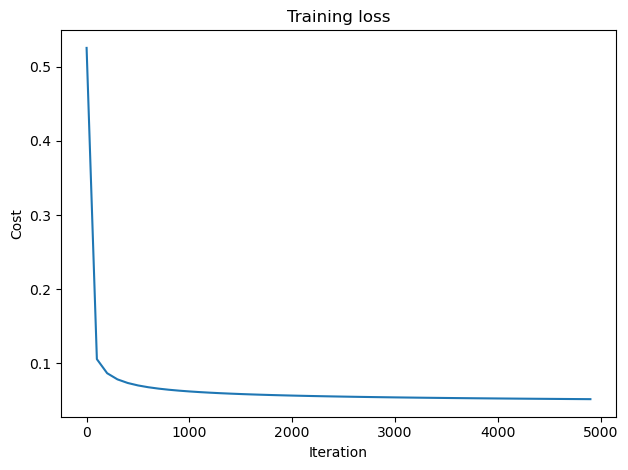

In [10]:
w, b, costs = fit_logistic_regression(
    X_train_scaled, y_train.values, lr=0.1, n_iter=5000
)

plt.plot(np.arange(0, len(costs))*100, costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Training loss')
plt.tight_layout()

In [11]:
def predict(X, w, b, threshold=0.5):
    """
    Predict binary labels using learned weights and bias.
    Inputs:
        X : Feature matrix (m, n)
        w : Weights (n,)
        b : Bias (scalar)
        threshold : Classification threshold (default = 0.5)
    Returns:
        Binary predictions (0 or 1)
    """
    probs = sigmoid(X @ w + b)
    return (probs >= threshold).astype(int)

# Make predictions on test set
y_pred_test = predict(X_test_scaled, w, b)

# Compute accuracy
accuracy_scratch = np.mean(y_pred_test == y_test.values)
print(f'Accuracy (from scratch): {accuracy_scratch:.4f}')

# Print learned coefficients
print('\nLearned coefficients (betas):')
for i, coef in enumerate(w):
    print(f'  beta_{i}: {coef:.4f}')
print(f'  bias (intercept): {b:.4f}')


Accuracy (from scratch): 0.9825

Learned coefficients (betas):
  beta_0: -0.4403
  beta_1: -0.4094
  beta_2: -0.4132
  beta_3: -0.5128
  beta_4: -0.2688
  beta_5: 0.5358
  beta_6: -0.9503
  beta_7: -1.0277
  beta_8: 0.2798
  beta_9: 0.4411
  beta_10: -1.6313
  beta_11: 0.0197
  beta_12: -0.9842
  beta_13: -1.1468
  beta_14: -0.3618
  beta_15: 1.1791
  beta_16: 0.0749
  beta_17: -0.4285
  beta_18: 0.3838
  beta_19: 0.8358
  beta_20: -1.3487
  beta_21: -1.3953
  beta_22: -1.0982
  beta_23: -1.2824
  beta_24: -0.8488
  beta_25: -0.1039
  beta_26: -1.1710
  beta_27: -1.0961
  beta_28: -1.2386
  beta_29: -0.6249
  bias (intercept): 0.1609


## Logistic Regression with scikit‑learn

### Switching to Scikit-Learn's Logistic Regression

With the mathematical foundations and our from-scratch routine in place, we will now switch to a **production-ready implementation** provided by `scikit-learn`.

This serves two complementary goals:

- **Speed & convenience** – The library’s C-optimised solvers yield the maximum-likelihood solution in milliseconds and expose a rich API for cross-validation, pipelines, and hyper-parameter tuning.

- **Validation of our handcrafted model** – By comparing predictions and performance metrics against the NumPy implementation, we can confirm that both reach essentially the same optimum.

---

### Road-map

| Step                          | Purpose                                                                                                  |
|------------------------------|----------------------------------------------------------------------------------------------------------|
| **Instantiate `LogisticRegression`** | Choose a solver (`lbfgs` is default), set `max_iter`, and decide on regularisation via the inverse penalty strength $C $. |
| **Fit on the training set**  | The model internally standardises nothing, so we feed it the already scaled features.                   |
| **Generate predictions**     | We will obtain both class labels (`predict`) and probabilities (`predict_proba`) to enable threshold-agnostic evaluation. |
| **Evaluate performance**     | Compute accuracy, confusion matrix, ROC-AUC, log-loss, and optionally precision-recall metrics — tools well suited to class-imbalance diagnostics. |
| **Inspect coefficients**     | Extract $\hat{\beta} $ values, convert them to odds ratios $e^{\beta_j} $, and discuss which predictors exert the strongest multiplicative effect on the class odds. |


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_sklearn = clf.predict(X_test_scaled)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

# Print results
print(f'Accuracy (scikit-learn): {accuracy_sklearn:.4f}\n')

# Print coefficients and intercept
print('\nLearned coefficients (betas):')
for i, coef in enumerate(clf.coef_[0]):
    print(f'  beta_{i}: {coef:.4f}')
print(f'  bias (intercept): {clf.intercept_[0]:.4f}')


Accuracy (scikit-learn): 0.9912


Learned coefficients (betas):
  beta_0: -0.3939
  beta_1: -0.3607
  beta_2: -0.3787
  beta_3: -0.4202
  beta_4: -0.2093
  beta_5: 0.3420
  beta_6: -0.7558
  beta_7: -0.8115
  beta_8: 0.1296
  beta_9: 0.3603
  beta_10: -1.1783
  beta_11: 0.0375
  beta_12: -0.7008
  beta_13: -0.8346
  beta_14: -0.2879
  beta_15: 0.8301
  beta_16: 0.1092
  beta_17: -0.3279
  beta_18: 0.2822
  beta_19: 0.5922
  beta_20: -1.0453
  beta_21: -1.0836
  beta_22: -0.8613
  beta_23: -0.9758
  beta_24: -0.5900
  beta_25: -0.0990
  beta_26: -0.8642
  beta_27: -0.8212
  beta_28: -0.9118
  beta_29: -0.4852
  bias (intercept): 0.2962


## Results & Comparison <a id="comparison"></a>

In [13]:
print(f'From‑scratch accuracy: {accuracy_scratch:.4f}')
print(f'scikit‑learn accuracy: {accuracy_sklearn:.4f}')
print(f'Difference: {accuracy_sklearn - accuracy_scratch:.4f}')

From‑scratch accuracy: 0.9825
scikit‑learn accuracy: 0.9912
Difference: 0.0088


### Interpreting the Accuracy Comparison

| Implementation                  | Test-set Accuracy |
|----------------------------------|-------------------|
| From-scratch (NumPy + gradient descent) | 0.9825            |
| scikit-learn (`LogisticRegression`)     | 0.9912            |
| **Absolute gap**                        | **0.0088** (≈ 0.9 percentage points) |

---

### What This Tells Us

- **Both models capture essentially the same signal.**  
  An accuracy in the high 98–99% range confirms that the underlying decision boundary learned from the data is nearly identical.

- **The small gap arises from solver and regularisation differences.**

  - **Solver:** Our hand-coded version uses plain batch gradient descent, whereas scikit-learn defaults to the **LBFGS optimiser**—a quasi-Newton method that usually converges to a slightly better optimum.

  - **Regularisation:** `LogisticRegression` applies **L2 penalty by default** (inverse strength $C = 1 $). Our manual model had **no penalty term**, so coefficients are unconstrained. A mild penalty can improve generalisation and nudge the likelihood to a marginally higher maximum.

---

### Practical Takeaway

A ~0.9 percentage point improvement is statistically minor in many contexts, yet it showcases the benefit of a **production-grade optimiser** with **sensible defaults**.

The close agreement **validates the maths** in the from-scratch implementation—an important sanity check before trusting more complex, custom code.

For deployment, you would typically rely on the **scikit-learn model** (or a more advanced pipeline), because it is:

- Faster to train  
- Easier to cross-validate  
- Provides built-in support for regularisation and probability calibration

---

### Final Thoughts

The result demonstrates that a **carefully written bare-bones implementation** can rival a library solution, while the library still offers **marginal gains** and **far greater convenience** for production workflows.


## Practical Tips

### Handling Class Imbalance

Real-world datasets often contain far fewer positive cases than negatives (e.g., fraud ≪ non-fraud, churn ≪ retained).  
If left untreated, a classifier can achieve deceptively high accuracy by **always predicting the majority class**.

Below are proven tactics—organised from **simplest to most sophisticated**—to mitigate that bias.

---

### Common Approaches to Class Imbalance

| Approach                     | Core Idea                                                                                  | Pros                                                                 | Cons / Caveats                                                              |
|-----------------------------|---------------------------------------------------------------------------------------------|----------------------------------------------------------------------|------------------------------------------------------------------------------|
| **Resample the data**       | Under-sample the majority class or over-sample the minority (e.g., random duplication, SMOTE). | Model remains unchanged; easy to reason about.                        | Under-sampling discards information; naïve over-sampling can overfit.       |
| **Weighted (cost-sensitive) loss** | Assign a larger weight $w $ to minority observations in the log-likelihood:<br> $J(\boldsymbol{\beta}) = -\sum_{i=1}^m w_i \left[y_i \log p_i + (1 - y_i)\log(1 - p_i)\right] $<br>Common choice: $w_i = \frac{m}{2 \cdot \text{count}(y_i)} $ | Uses full data; integrates with gradient-based solvers.              | Must tune or cross-validate weights; extreme weights can cause instability. |
| **Adjust the decision threshold** | Default threshold 0.5 maximises accuracy only for balanced data. Choose $\tau $ that maximises $F_\beta $ or minimises expected cost.<br> Predict “positive” if $p_i \geq \tau $. | Simple post-processing; no model retrain needed.                      | Only changes decision rule, not model boundary.                            |
| **Custom evaluation metrics** | Optimise for precision-recall AUC, $F_1 $, MCC, or expected cost instead of accuracy.     | Forces hyper-parameter search to respect minority performance.        | Requires domain knowledge to select appropriate metrics.                    |
| **Hybrid or ensemble methods** | Combine logistic regression with tree-based models on balanced bootstraps; or stack predictions and weight them. | Captures linear interpretability + nonlinear patterns; boosts recall. | More complex; interpretability of the ensemble may decrease.                |

---

### Mathematical Intuition Behind Weighting

For class weights $w_0 $ and $w_1 $ assigned to negatives and positives respectively, the **weighted gradient** becomes:

$$
\nabla_{\boldsymbol{\beta}} J = \sum_{i=1}^{m} w_{y_i} (p_i - y_i) \mathbf{x}_i, \quad p_i = \sigma(\mathbf{x}_i^\top \boldsymbol{\beta})
$$

A larger $w_1 $ amplifies the error term for minority instances, steering the optimiser to reduce **false negatives** at the expense of some **false positives**—exactly what you want when a missed positive is costlier.

---

### When to Use Which Tactic?

- **Mild imbalance (≤ 4:1)**  
  Weighted loss or threshold tuning alone often suffices.

- **Moderate to severe imbalance (5:1 – 100:1)**  
  Combine weighted loss with intelligent over/under-sampling (e.g., SMOTE + Tomek links).

- **Extreme imbalance (≫ 100:1)**  
  Consider anomaly detection framing or hybrid ensembles; supplement evaluation with business-cost analysis.

---

By consciously addressing imbalance, the logistic-regression pipeline remains both **predictive and fair**, yielding **calibrated probabilities** that truly reflect minority-class risk.


### Feature Scaling — Why It Matters and How to Do It

**Feature scaling** is the practice of transforming predictors so they share a common numerical scale.  
Although logistic regression is scale-invariant *in theory*—the decision boundary depends only on sign changes of $ \beta_j x_j $—in practice, scaling has far-reaching effects on **optimisation**, **regularisation**, and **interpretability**.

---

### Impact of (Not) Scaling

| Aspect                   | Impact                                                                                                                                |
|--------------------------|---------------------------------------------------------------------------------------------------------------------------------------|
| **Gradient-based solvers** | The loss surface becomes ill-conditioned when features are on drastically different scales. Step sizes that suit “age in years” may cause divergence for “income in dollars”. Scaling makes the Hessian closer to spherical, so gradient descent or LBFGS converges in fewer iterations. |
| **Regularisation**         | $ L_1 $ and $ L_2 $ penalties shrink $ \|\boldsymbol{\beta}\| $. Without scaling, variables with large units get over-penalised, biasing feature selection. With scaling, each predictor pays a comparable regularisation cost. |
| **Coefficient comparison** | A raw coefficient reflects a one-unit change in the original units (e.g., \$1). After standardisation, it reflects a one-standard-deviation change, enabling direct ranking of variable importance. |
| **Numeric stability**      | Extremely large or tiny values can trigger floating-point overflow in the sigmoid $ \sigma(z) $. Scaling brings $ z = \mathbf{x}^\top \boldsymbol{\beta} $ into a numerically safe range. |

---

### Common Scaling Strategies

| Method                | Formula                                      | When to Use                                                                 |
|-----------------------|----------------------------------------------|------------------------------------------------------------------------------|
| **Z-score standardisation** | $ x^* = \frac{x - \mu}{\sigma} $               | Default choice for gradient-based models; mean 0, SD 1.                      |
| **Min–max scaling**        | $ x^* = \frac{x - x_{\min}}{x_{\max} - x_{\min}} $ | Needed when features must lie in $[0, 1]$, e.g., neural nets with sigmoid/tanh. |
| **Robust scaling**         | $ x^* = \frac{x - \text{median}}{\text{IQR}} $      | Resistant to heavy-tailed outliers.                                         |
| **Log / power transforms** | $ x^* = \log(x + 1) $ or Box–Cox                   | For strictly positive, highly skewed distributions (e.g., income).          |

---

### Best Practices

- **Fit the scaler on the training set only**  
  Compute $ \mu $ and $ \sigma $ (or other parameters) on $ X_{\text{train}} $ to avoid leaking information from the test set.

- **Apply the same transformation to all future data**  
  Store the fitted parameters and reuse them during inference or deployment.

- **Combine scaling with pipelines**  
  In scikit-learn, wrap `StandardScaler()` and `LogisticRegression()` in a `Pipeline` to guarantee consistent preprocessing during cross-validation.

- **Check for categorical dummies**  
  One-hot-encoded binaries $\{0, 1\}$ are already on a comparable scale—scaling them is harmless but not required.

---

### Key Takeaway

Scaling is **not merely cosmetic**; it directly improves:

- Convergence speed  
- Regularisation fairness  
- Numerical robustness  
- Interpretability  

Always include feature scaling as a **first-class step** in your preprocessing pipeline.


### Regularisation — Taming Over-fitting and Selecting Features

Logistic regression maximises the log-likelihood, but nothing in that criterion penalises overly complex models.  
**Regularisation** adds a complexity term to the objective, discouraging extreme coefficient values that over-fit noise.

---

### 1 Penalised Objective

$$
-\sum_{i=1}^m \left[ y_i \log p_i + (1 - y_i) \log(1 - p_i) \right] \quad \text{(Negative log-likelihood)} \\
+ \quad \lambda \, \Omega$boldsymbol{\beta}) \quad \text{(Penalty)} \quad \longrightarrow \min_{\boldsymbol{\beta}}, \quad p_i = \sigma$mathbf{x}_i^\top \boldsymbol{\beta})
$$

- $ \lambda \geq 0 $ controls the **strength** of the penalty.
- $ \Omega$boldsymbol{\beta}) $ defines which kind of **shrinkage** we impose.

---

### 2 Common Penalty Types

| Penalty         | Form $ \Omega$boldsymbol{\beta}) $                          | Behaviour                                                                 | Typical Use-Case                                               |
|-----------------|----------------------------------------------------------------|---------------------------------------------------------------------------|----------------------------------------------------------------|
| **L2 (Ridge)**  | $ \frac{1}{2} \sum_{j=1}^k \beta_j^2 $                       | Shrinks coefficients continuously; keeps all features but smaller.       | Multicollinearity control, smooth shrinkage when all features carry signal. |
| **L1 (Lasso)**  | $ \sum_{j=1}^{k} |\beta_j| $                                 | Encourages sparsity; eliminates irrelevant features.                      | Feature selection, interpretability.                          |
| **Elastic Net** | $ \alpha L_1 + (1 - \alpha) L_2 $                            | Blend of L1 and L2; balances sparsity with stability under collinearity. | Genomics, text, or $ k \gg m $ problems.                    |

> **Note:** In scikit-learn, regularisation strength is parameterised as $ C = \frac{1}{\lambda} $.  
Smaller $ C $ ⇒ stronger penalty.

---

### 3 Intuitive Effect

Penalised coefficients are equivalent to posterior modes under zero-centred priors:

| Penalty | Bayesian Prior               |
|---------|------------------------------|
| L2      | $ \beta_j \sim \mathcal{N}(0, \tau^2) $     |
| L1      | $ \beta_j \sim \text{Laplace}(0, b) $       |

Thus, regularisation expresses a **prior belief** that large weights are unlikely unless the data provide strong evidence.

---

### 4 Choosing $ \lambda $ (or $ C $)

- **Cross-validation**  
  Split training data; fit across a **logarithmic grid** of $ \lambda $; select value that maximises ROC-AUC or minimises log-loss.

- **Information criteria**  
  AIC/BIC can be adapted to penalised likelihoods.

- **Domain knowledge**  
  Regulatory models (e.g., credit scoring) may impose limits on coefficient magnitudes.

---

### 5 Interplay with Feature Scaling

Penalties act on **absolute coefficient values**.

- If predictors are **unscaled**, features measured in large units appear artificially “small” and may dodge the penalty.
- **Always scale** features before applying regularisation to ensure **equitable shrinkage**.

---

### 6 Practical Guidelines

- **Start with L2** for balanced, low-dimensional problems — it typically improves generalisation with minimal interpretability cost.
- **Try L1 or Elastic Net** when you expect **many irrelevant or collinear predictors**. Inspect the sparsity pattern for insights.
- **Monitor validation loss vs. $ \lambda $** — an “elbow” often marks the sweet spot between **variance and bias**.
- Remember: **too much regularisation = under-fitting**. Aim for just enough shrinkage to curb noise without erasing signal.

---

### Final Takeaway

By incorporating regularisation into logistic regression, you obtain models that:

- Generalise better  
- Remain numerically stable  
- Optionally reveal the **most informative features**


### Model Interpretation — Turning Coefficients into Actionable Insights

Logistic regression is prized for the clarity with which it links predictors to class probabilities.  
Once the model is trained, interpretation proceeds along several complementary axes.

---

### Interpretive Lenses

| Lens                         | What You Examine                                                      | How to Read It                                                                                                 |
|------------------------------|------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------|
| **Sign of a coefficient**    | $ \beta_j $                                                         | $ > 0 \Rightarrow $ predictor increases log-odds of the positive class; $ < 0 \Rightarrow $ decreases them. |
| **Magnitude on log-odds scale** | $ \beta_j $                                                         | Indicates how strongly $ x_j $ influences the log-odds; useful for ranking importance (if scaled).            |
| **Odds ratio**               | $ e^{\beta_j} $                                                     | Multiplicative change in odds for a one-unit (or one-SD) increase in $ x_j $. Example: $ e^{0.7} \approx 2.0 $ doubles the odds. |
| **Confidence interval**      | $ \beta_j \pm 1.96 \cdot SE(\beta_j) $                              | If the interval crosses 0, the effect is not statistically distinguishable from noise at the 5% level.         |
| **Average Marginal Effect (AME)** | $ \frac{1}{m} \sum_{i=1}^m p_i(1 - p_i)x_{ij} $                      | Expected change in **probability**, not log-odds, when $ x_j $ rises by one unit; more intuitive for stakeholders. |
| **Partial dependence**       | $ \hat{p}(x_j, \text{rest}) $ plotted across a range               | Visualises how predicted probability changes with one feature holding others fixed.                            |
| **Interaction terms**        | $ \beta_{jk} x_j x_k $                                              | A significant $ \beta_{jk} $ means the effect of $ x_j $ depends on $ x_k $; interpret with plots or marginal effects. |
| **Global vs. local explanation** | Global: coefficients, AME<br>Local: $ \Delta \log \text{odds} = \boldsymbol{\beta}^\top$mathbf{x} - \mathbf{x}_{\text{ref}}) $ | Global tells “which features matter overall,” local explains “why this specific prediction is high/low.”        |

---

### Interpreting the Intercept

The intercept $ \beta_0 $ equals the **log-odds when all predictors are zero** (or at their means if features were centred).  
Exponentiating gives the **baseline odds**: $ e^{\beta_0} $.  
This provides context for how much each feature shifts the model away from the base rate.

---

### Regularisation Caveat

Shrinking coefficients alters their magnitudes.  
**Odds ratios from a heavily penalised model** reflect both **signal and the bias** introduced by regularisation.

> When interpretability is paramount, consider:
- Using a **milder penalty**, or  
- Presenting **unpenalised coefficients** alongside penalised predictions

---

### Communicating Results

- **Translate odds ratios to plain language**  
  > “A one-SD increase in tumour radius multiplies the odds of malignancy by 2.3×, holding all other variables constant.”

- **Quantify uncertainty**  
  Report **95% confidence intervals** or **p-values** to show which effects are statistically robust.

- **Show practical impact**  
  Convert log-odds shifts into **absolute probability changes** at meaningful baselines (e.g., from 5% to 9%).

---

### Final Takeaway

By combining:
- **Coefficient signs**
- **Odds ratios**
- **Marginal effects**
- **Confidence intervals**

Logistic regression offers a **transparent bridge** between statistical modelling and decision-making.


### Example for Interpreting the coefficients


| Coefficient            | Value    | On the Log-Odds Scale                                      | As an Odds Ratio                  | Practical Meaning*                                                                 |
|------------------------|----------|-------------------------------------------------------------|------------------------------------|-------------------------------------------------------------------------------------|
| **Intercept** $( \beta_0 $)    | 0.2962   | Baseline log-odds when all predictors are zero (or at their means, if standardised) | $ e^{0.2962} \approx 1.34 $      | Baseline odds of the positive class are **1.34 : 1** → a baseline probability of ≈ **57%** |
| **Feature 29** $( \beta_{29} $) | −0.4852  | Change in log-odds for a one-unit ↑ in $ x_{29} $         | $ e^{-0.4852} \approx 0.62 $     | Multiplies the odds by **0.62×** (i.e., reduces them by **38%**)                  |

\* *Assuming the model was fit after z-score standardisation of the predictors.*

---

#### **Intercept (Baseline Risk)**

When every feature is at its reference level (zero after standardisation), the model’s log-odds are **0.2962**.

**Converting log-odds to probability:**

$$
p_0 = \frac{e^{0.2962}}{1 + e^{0.2962}} \approx 0.57
$$

So, even before considering any features, the event is **slightly more likely than not** (57% chance).

---

#### **Feature 29**

A **one-unit increase** in $x_{29}$(i.e., one standard deviation) lowers the log-odds by **0.4852**.

**Odds ratio:**

$$
e^{-0.4852} \approx 0.62
$$

This means the odds of the positive outcome are **38% lower** for each such increase.

---

**Example at the baseline:**

Let the initial odds be 1.34 (from baseline probability):

$$
\text{new odds} = 1.34 \times 0.62 \approx 0.83
$$
$$
\text{new probability} = \frac{0.83}{1 + 0.83} \approx 0.45
$$

Thus, raising $x_{29}$by one standard deviation **drops the predicted probability from 57% to about 45%**.

---

#### **Interpretation in Plain Language**

> Holding all other variables constant, **feature 29 has a protective (negative) effect**:  
> Increasing it by one standard deviation **cuts the odds** of the positive class by roughly a third, reducing the predicted probability from **a bit over one-half to just under one-half**.


### How the Coefficients Shape the Logistic S-Curve

![How the Coefficients Shape the Logistic S-Curve](images/How%20the%20Coefficients%20Shape%20the%20Logistic%20S-Curve.png)

The logistic model with a single predictor can be written as:

$$
p(x) = \sigma(z) = \frac{1}{1 + e^{-z}}, \quad z = \beta_0 + \beta_1 x
$$

The picture above visualises three key geometric facts:

---

### Geometric Interpretation of Logistic Coefficients

| Geometric Feature on the Plot                | Algebraic Expression                              | Interpretation                                                                 |
|----------------------------------------------|----------------------------------------------------|---------------------------------------------------------------------------------|
| **Horizontal shift of the curve** (grey line) | $x = -\frac{\beta_0}{\beta_1}$                  | The inflection point where $p = 0.5$. The intercept $\beta_0$ shifts the S-curve left or right. |
| **Steepness** (slope of dashed tangent)       | $\frac{dp}{dx} \bigg|_{p=0.5} = \frac{\beta_1}{4}$ | The derivative of the sigmoid at the midpoint; higher $\beta_1$ = steeper curve. |
| **Width of transition band** (red arrow)      | Central decile span ≈ $\frac{4.394}{\beta_1}$     | Range of $x$ where $p(x) \in [0.1, 0.9]$; inversely proportional to steepness. |
| **Direction of change**                       | Sign of $\beta_1$                                 | If $\beta_1 > 0$, $p(x)$ increases with $x$; if $\beta_1 < 0$, $p(x)$ decreases. |

---

### Putting It Together

- **Intercept $\beta_0$**  
  Sets the **horizontal position** of the curve but **does not affect its steepness**.  
  It is the log-odds when $x = 0$.

- **Slope $\beta_1$**  
  Governs the **scale of the x-axis**:
  - **Steeper curve** ⇒ model is more **certain** (probabilities quickly approach 0 or 1).
  - **Flatter curve** ⇒ model is more **uncertain** (probabilities stay near 0.5 over a wider range).
  - **Negative $\beta_1$** ⇒ the S-curve **flips**, becoming a decreasing function of $x$.

---

### Extension to Multivariate Case

These geometric insights extend to multivariate logistic regression:

- Each coefficient $\beta_j$ **tilts the surface** along feature $x_j$
- The intercept vector $\beta_0$ **shifts the entire decision surface**

Visualising the one-dimensional slice helps clarify **how changes in coefficient magnitude or sign reshape the probability landscape**.


## Conclusion

Over the course of this notebook we have:

- **Motivated logistic regression** as the canonical model for binary outcomes, contrasting it with linear regression and highlighting the probabilistic interpretation of the sigmoid link.

- **Built the algorithm from scratch**—deriving the likelihood, gradients, and a gradient-descent optimiser—thereby demystifying what high-level libraries do under the hood.

- **Validated our hand-rolled model** against `scikit-learn`, discovering that a production-grade solver with mild L2 regularisation can squeeze out an extra sliver of accuracy while confirming our implementation’s correctness.

- **Added practical engineering layers**:
  - **Feature scaling** for faster convergence, fair regularisation, and interpretable coefficients.
  - **Class-imbalance strategies** such as weighted loss, resampling, and threshold tuning.
  - **Regularisation** (L1, L2, Elastic Net) to control over-fitting and encourage sparsity.

- **Explored model interpretation**—signs, magnitudes, odds ratios, marginal effects—culminating in a **geometric view** of how $ \beta_0$ and $ \beta_1$ shift and stretch the S-curve.

---

### Key Takeaways

- **Logistic regression remains a first-stop classifier**: simple, fast, interpretable, yet surprisingly powerful when properly pre-processed and regularised.

- **Understanding the mathematics** (likelihood, gradient, penalty) equips you to:
  - Diagnose convergence issues  
  - Justify weighting schemes  
  - Communicate effect sizes in plain language

- **Scaling, regularisation, and imbalance handling** are not afterthoughts—they are **integral** to building reliable, generalisable models.

---

Armed with these foundations, you can confidently:

- Apply logistic regression to real-world problems  
- Benchmark more complex algorithms  
- Explain your findings to both technical and non-technical stakeholders
